# Proyectos de Kickstarter

Para esta semana, deberá utilizar los datos de (proyectos.csv aprox 58Mb) donde encontrará 378 mil proyectos de Kickstarter. No todos los proyectos son exitosos. Ud deberá construir un modelo con Naibe Bayes Gaussiano y KNN para predecir el estado del proyecto.

## Datos:

- y: state (failed, canceled, succesful, live, suspended, etc..)

- X:
    - ID: identificador del proyecto
    - name: nombre del proyecto
    - category: sub-categoria del proyecto
    - main_category: categoria del proyecto
    - currency: moneda de la peticion.
    - deadline: fecha de vencimiento del proyecto
    - goal: dinero a obtener en el proyecto
    - launched: fecha de inicio del proyecto
    - pledged: dinero solicitado por la comunidad
    - backers: cantidad de donantes de dinero
    - country: pais de origen del proyecto
    - usd_pledged: conversion en dolares de la columna pledged
    - usd_pledged_real: conversion en dolares de la columna pledged por Fixer.io API
    - usd_goal_real: conversion en dolares de la columna goal por Fixer.io API
    
### Problema Semanal:

Ud tiene duda de cual modelo de machine learning funciona mejor para este problema, si KNN o Naive Bayes Gaussiano. Para esto ud deberá realizar el analsis necesario de escogencia de modelos para determina cual es el mejor modelo.

### Algunas recomendaciones:

- considere no utilizar proyectos que estan con estado "Live".
- puede crear o eliminar columnas segun lo considere necesario.
- utilize transformaciones, scaling, normalizacion y feature engineering para "tunear" su modelo.
- utilize la matrix de confusion y las metricas de F1Score, etc para comparar los modelos.
- Puede utilizar test-train split. Considere un test set del (+-)30%.
- utilize diversions hiperparametros para encontrar el mejor fit a su problema.
- utilize el chat de WhatsApp para apoyar a sus companeros y hacer preguntas.
- Si ud inicia este proyecto el viernes en la manana, probablemente no va a poder terminar. Do it on time. 
- haga drop de la columna name, ya que no hemos visto nada de NLP.

### Descargar Datos:
Los datos para este proyecto estan en el aula virtual en semana 6.

In [102]:
# ANTORCHA!
# feature engineering (transformacion, norm, eliminar var, etc...): 5 pts
# entrenamiento de modelos: 5pts
# model selection: uso de metricas para comprar modelos y matrices de confusion: 5 pts
# considere crear un resumen al final donde se puedan comparar las metricas "taco-a-taco" 
# para que quede bien explicado cual modelo es el mejor.

In [151]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [172]:
# Load data
df = pd.read_csv('data/proyectos.csv')

# Remove not valid states
df = df[df.state != 'live']
df = df[df.state != 'undefined']

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [173]:
# Remove features
df = df.drop(['ID', 'name'], axis=1)

# Convert to the right format
df['deadline']= pd.to_datetime(df['deadline']) 
df['launched']= pd.to_datetime(df['launched'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372300 entries, 0 to 378660
Data columns (total 13 columns):
category            372300 non-null object
main_category       372300 non-null object
currency            372300 non-null object
deadline            372300 non-null datetime64[ns]
goal                372300 non-null float64
launched            372300 non-null datetime64[ns]
pledged             372300 non-null float64
state               372300 non-null object
backers             372300 non-null int64
country             372300 non-null object
usd pledged         372066 non-null float64
usd_pledged_real    372300 non-null float64
usd_goal_real       372300 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(1), object(5)
memory usage: 39.8+ MB


In [174]:
# Encode target variable
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(df[['state']])

df['state'] = enc.transform(df[['state']])

In [179]:
# Extract features from datetime 

df['deadline_year'] = df['deadline'].dt.year
df['deadline_month'] = df['deadline'].dt.month

df['launched_year'] = df['launched'].dt.year
df['launched_month'] = df['launched'].dt.month

# Remove old features
df = df.drop(['deadline', 'launched'], axis=1)

df.head()

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month
0,Poetry,Publishing,GBP,1000.0,0.0,1.0,0,GB,0.0,0.0,1533.95,2015,10,2015,8
1,Narrative Film,Film & Video,USD,30000.0,2421.0,1.0,15,US,100.0,2421.0,30000.00,2017,11,2017,9
2,Narrative Film,Film & Video,USD,45000.0,220.0,1.0,3,US,220.0,220.0,45000.00,2013,2,2013,1
3,Music,Music,USD,5000.0,1.0,1.0,1,US,1.0,1.0,5000.00,2012,4,2012,3
4,Film & Video,Film & Video,USD,19500.0,1283.0,0.0,14,US,1283.0,1283.0,19500.00,2015,8,2015,7


In [180]:
# Corr Matrix
corr = df.corr()
corr.style.background_gradient(cmap='plasma').set_precision(2)

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month
goal,1,0.0073,-0.022,0.004,0.0056,0.0051,0.94,0.017,0.00027,0.016,0.00095
pledged,0.0073,1,0.095,0.72,0.86,0.95,0.0051,0.03,0.0057,0.03,0.0024
state,-0.022,0.095,1,0.11,0.084,0.095,-0.02,-0.085,-0.0058,-0.08,-0.013
backers,0.004,0.72,0.11,1,0.7,0.75,0.0045,0.017,0.0033,0.017,-0.0023
usd pledged,0.0056,0.86,0.084,0.7,1,0.91,0.0062,-0.0066,-0.0033,-0.0062,-0.0059
usd_pledged_real,0.0051,0.95,0.095,0.75,0.91,1,0.0056,0.022,0.0041,0.023,8e-05
usd_goal_real,0.94,0.0051,-0.02,0.0045,0.0062,0.0056,1,0.013,0.00057,0.012,0.0013
deadline_year,0.017,0.03,-0.085,0.017,-0.0066,0.022,0.013,1,-0.074,0.99,-0.036
deadline_month,0.00027,0.0057,-0.0058,0.0033,-0.0033,0.0041,0.00057,-0.074,1,-0.017,0.61
launched_year,0.016,0.03,-0.08,0.017,-0.0062,0.023,0.012,0.99,-0.017,1,-0.089


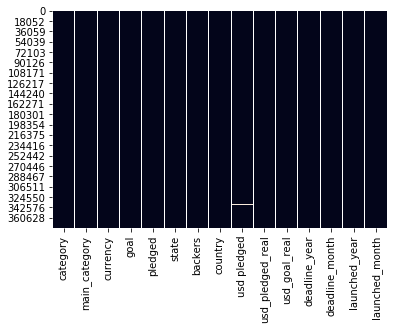

In [181]:
# Review NN
import seaborn as sns

sns.heatmap(df.isnull(), cbar=False)

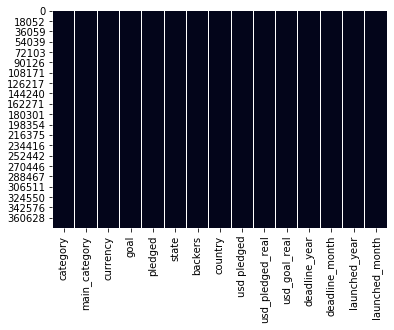

In [182]:
# Fill NN
# df2 = df.copy()
df['usd pledged'] = df['usd pledged'].fillna(df['usd pledged'].median())

sns.heatmap(df.isnull(), cbar=False)

In [183]:
# Transform
# One Hot Encoding
df_onehot = df.copy()

# df_onehot = df_onehot.drop(['id', 'name'], axis=1)

def onehot_encode(df, feature):
    enc = OrdinalEncoder()
    cp_dummies = pd.get_dummies(df[feature], prefix=feature)
    new_df = df.drop([feature], axis=1)
    return new_df.join(cp_dummies)

df_onehot = onehot_encode(df_onehot, 'category')
df_onehot = onehot_encode(df_onehot, 'main_category')
df_onehot = onehot_encode(df_onehot, 'currency')
df_onehot = onehot_encode(df_onehot, 'country')


In [184]:
corr_onehot = df_onehot.corr()
corr_onehot["state"].sort_values(ascending=False)

state                       1.000000
backers                     0.110432
main_category_Music         0.099395
pledged                     0.095448
usd_pledged_real            0.094587
                              ...   
category_Apps              -0.070938
category_Video Games       -0.071470
launched_year              -0.080446
deadline_year              -0.084755
main_category_Technology   -0.088921
Name: state, Length: 222, dtype: float64

In [185]:
# data split
from sklearn.model_selection import train_test_split

y = df_onehot['state']
X = df_onehot.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [186]:
###################
# Entrenamiento KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

# Predictions
knn_y_prima = knn.predict(X_test)
knn_y_prima

array([1., 1., 2., ..., 1., 1., 1.])

In [187]:
# accuracy_score(y_test, knn_y_prima)

knn_accuracy = (knn_y_prima == y_test).mean()

print('KNN Accuracy ', knn_accuracy)

KNN Accuracy  0.8739636493866954


In [190]:
# from sklearn.metrics import classification_report

class_names = ['canceled', 'failed', 'successful', 'suspended']

np.set_printoptions(precision=2)
accuracy_score(y_test, knn_y_prima)

print(classification_report(y_test, knn_y_prima, target_names=class_names))

              precision    recall  f1-score   support

    canceled       0.21      0.06      0.09     11627
      failed       0.84      0.96      0.89     59336
  successful       0.99      1.00      0.99     40159
   suspended       0.00      0.00      0.00       568

    accuracy                           0.87    111690
   macro avg       0.51      0.50      0.49    111690
weighted avg       0.82      0.87      0.84    111690



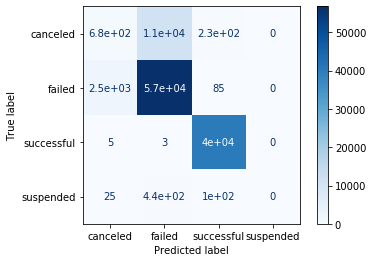

KNN Matriz
[[  675 10719   233     0]
 [ 2464 56787    85     0]
 [    5     3 40151     0]
 [   25   442   101     0]]


In [191]:
from sklearn.metrics import plot_confusion_matrix

# np.set_printoptions(precision=2)

disp = plot_confusion_matrix(knn, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None)
plt.show()
print("KNN Matriz")
print(disp.confusion_matrix)

In [192]:
# Naive Bayes Gaussiano
# Model
from sklearn.naive_bayes import GaussianNB

gau_model = GaussianNB()

gau_y_prima = gau_model.fit(X_train, y_train).predict(X_test)

In [193]:
########################
# Naive Bayes Gaussiano   
# Metrics
gnb_accuracy = accuracy_score(y_test, gau_y_prima)
print("GNB Accuracy:", gnb_accuracy)
print(classification_report(y_test, gau_y_prima, target_names=class_names))

GNB Accuracy: 0.6256424030799534
              precision    recall  f1-score   support

    canceled       0.27      0.01      0.02     11627
      failed       0.59      0.98      0.74     59336
  successful       0.92      0.29      0.44     40159
   suspended       0.01      0.01      0.01       568

    accuracy                           0.63    111690
   macro avg       0.45      0.32      0.30    111690
weighted avg       0.67      0.63      0.55    111690



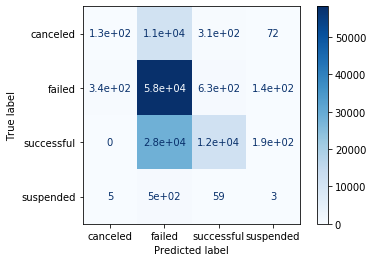

GNB Matrix
[[  129 11114   312    72]
 [  337 58234   626   139]
 [    0 28461 11512   186]
 [    5   501    59     3]]


In [196]:
gau_disp = plot_confusion_matrix(gau_model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None)
plt.show()
print("GNB Matrix")
print(gau_disp.confusion_matrix)

In [198]:
# Metrics summary
print('GNB', classification_report(y_test, gau_y_prima, target_names=class_names))
print('KNN', classification_report(y_test, knn_y_prima, target_names=class_names))

GNB               precision    recall  f1-score   support

    canceled       0.27      0.01      0.02     11627
      failed       0.59      0.98      0.74     59336
  successful       0.92      0.29      0.44     40159
   suspended       0.01      0.01      0.01       568

    accuracy                           0.63    111690
   macro avg       0.45      0.32      0.30    111690
weighted avg       0.67      0.63      0.55    111690

KNN               precision    recall  f1-score   support

    canceled       0.21      0.06      0.09     11627
      failed       0.84      0.96      0.89     59336
  successful       0.99      1.00      0.99     40159
   suspended       0.00      0.00      0.00       568

    accuracy                           0.87    111690
   macro avg       0.51      0.50      0.49    111690
weighted avg       0.82      0.87      0.84    111690



In [199]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

knn_recall = recall_score(y_test, knn_y_prima, average='macro')
gnb_recall = recall_score(y_test, gau_y_prima, average='macro')
knn_f1 = f1_score(y_test, knn_y_prima, average='macro')
gnb_f1 = f1_score(y_test, gau_y_prima, average='macro')

d = {
    'Model': ['KNN', 'GNB'], 
    'Accuracy': [knn_accuracy, gnb_accuracy],
    'Recall': [knn_recall, gnb_recall],
    'F1-Score': [knn_f1, gnb_f1]
}
models_df = pd.DataFrame(data=d)
models_df

,Model,Accuracy,Recall,F1-Score
0,KNN,0.873964,0.503724,0.494555
1,GNB,0.625642,0.321116,0.300868


In [134]:
print('El mejor modelo: ', 'KNN')

El mejor modelo:  KNN
